In [1]:
import pathlib
import sys
import socket
import time

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

import MDAnalysis as mda

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

import torch
from torch import nn, optim


# Ortholoss

Käytetään lisäämään latentin avaruuden ortogonaalisuutta.

Jos loss laksetaan yleensä esim
```
mse_loss = MSELoss()
loss = mse_loss(decoded, X_in)
```
voi tämän lossin lisätä siihen
```
ortho_loss = OrthoLoss()
loss += ortho_loss(encoded)
```

In [2]:
class OrthoLoss(nn.Module):
    
    def __init__(self, type="mse", reduction="mean"):
        """
        A loss function for making a latent space orthonormal. In this case orthonormality
        means that given an input matrix X of shape(n, d) of n data points
        of d-dimensions, (X.T @ X) / n will be a d-dimensional identity matrix. The divisor
        of n makes sure that if batch size is changed, the orthonormality condition stays the same.
        
        The loss defined by "type" is calculated over the (d,d) shaped error matrix (X.T @ X) / n - eye(d).
        
        The batch size should be sufficiently large and decorrelated for this loss to work.
        
        Parameter
        ---------
        type: one of ("mse", "l1", "l2"), default="mse"
            How the loss is calculated from the error matrix.
            mse: mean squared error (squared l2 error)
            l1:  mean absolute error
            l2:  root mean squared error
        reduction: one of ("sum", "mean"), default="mean"
            How different batch size affects the result. With "mean" the error magnitude should stay
            the same independent of the batch size. With "sum" the error matrix above is multiplied
            by batch size, so the error grows linearily with batch size.
            NOTE! due to  the error being calculated for the whole batch at once, the sum-reduction
            has a different meaning to most other loss functions. With the mse type the output scales
            as squared to the batch size instead of linearily, since the reduction is applied before
            squaring.
        """
        super().__init__()
        
        types = {"mse": self._mse,
                 "l1":  self._l1,
                 "l2":  self._l2}
        errors = {"sum":  self._sum_error,
                  "mean": self._mean_error}

        if type not in types:
            raise ValueError(f"Unrecognised loss type \"{type}\"")
        if reduction not in errors:
            raise ValueError(f"Unrecognised loss reduction \"{reduction}\"")
        self.type=type
        self.reduction=reduction
        self._calc_loss = types[type]
        self._calc_err  = errors[reduction]
    
    def forward(self, X):
        n = X.shape[0]
        d = X.shape[1]
        nc_var = X.T @ X
        target = torch.eye(d, device=X.device)
        error = self._calc_err(nc_var, target, n)
        return self._calc_loss(error, d)
    
    def _mse(self, error, d):
        return (error*error).mean()
    
    def _l2(self, error, d):
        return self._mse(error,d).sqrt()
    
    def _l1(self, error, d):
        return torch.abs(error).mean()
    
    def _mean_error(self, dp, tgt, n):
        return dp/n - tgt
        
    def _sum_error(self, dp, tgt, n):
        return dp - tgt*n


In [3]:
# settings
wrk_path = pathlib.Path("/wrk")
if (socket.gethostname() == "dx9-528-11187"):
    wrk_path = pathlib.Path("/wrk2")
elif (socket.gethostname() == "dx8-5282-001"):
    wrk_path = pathlib.Path("/home/wrk2")

# settings
path = wrk_path / "paajasan" / "fst_applications" / "NMDA"

processes = ["no-Glu", "no-Gly", "desensitization", "inactivation"]
parts = ["prot", "lbd", "atd", "tmd"]
data_folder = "analysis"
selection_strings = {
    "prot": "protein and ( not resid 821 to 824 ) and not type H",
    "atd": "resid 1 to 370",
    "lbd": "(chainid A C and resid 371 to 507 650 to 765) or " \
           "(chainid B D and resid 371 to 520 640 to 775)",
    "linker": "(chainid A C and resid 508 to 517 621 to 649 766 to 780) or " \
              "(chainid B D and resid 521 to 530 635 to 639 776 to 784)",
    "tmd": "(chainid A C and resid 518 to 620 781 to 820) or " \
           "(chainid B D and resid 531 to 634 785 to 820)",
    }



# Get which indexes to load
clip_file = path / "PLS" / "results" / "coord_clipping_2.npz" 
max_data = 25000
indexes = {}
for process in processes:
    with np.load(clip_file) as dat:
        indexes[process] = dat[f"{process}/{max_data}/indx"]

# Load fval and keep track which process each frame comes from
ndxsum = sum([len(indexes[process]) for process in processes])
fval = np.empty(ndxsum,dtype=np.float32)
proc = np.empty(ndxsum,dtype=int)

isum=0
for i,process in enumerate(processes):
    print(process)
    dat_path = path / process / "analysis" / "data.npz"
    ndx = indexes[process]
    nextisum = isum+len(ndx)
    with np.load(dat_path) as npz:
        fval[isum:nextisum] = npz["lurch"][ndx]
    
    proc[isum:nextisum] = i
    isum = nextisum

fval, proc

# Load coordinates
part="prot"
print(part)
u = mda.Universe(str(path / processes[0] / "analysis" / f"{part}.pdb"))
sel = u.select_atoms(selection_strings[part])
#sel = sel.select_atoms("name CA")

ndxsum = sum([len(indexes[process]) for process in processes])
X = np.empty((ndxsum, len(sel), 3))
isum=0
for process in processes:
    crd_path = path / process / "analysis" / f"{part}.xtc" 
    u.load_new(str(crd_path))
    ndx = indexes[process]
    for i,ts in enumerate(tqdm(u.trajectory[ndx], desc=process)):
        X[isum+i] = sel.positions
    isum += len(ndx)

X = X.reshape((X.shape[0],-1))
#rng = np.random.default_rng(0)
#rng.shuffle(coords)


print()

print(sel.__repr__())
print(sel.positions.shape, sel.positions.size)

In [4]:
X = np.load("CHOL_densities_2_20_a100.npy")
Y = np.load("a100_values_2_a100.npy")

print(X.shape, Y.shape)

(2855, 8000) (2855,)


In [5]:
# Test / train split

test = 0.2
index = np.arange(X.shape[0])
np.random.shuffle(index)
test_index = index[:int(test*len(index))]
train_index = index[int(test*len(index)):]
test_X = torch.Tensor(X[test_index,:])
train_X = torch.Tensor(X[train_index,:])

test_y = Y[test_index]
train_y = Y[train_index]


# Autoencooderi

Sekä init, että fit ottaa aika paljon enemmän parametrejä kuin ennen. Initissä tärkein muutos on device parametri. Ajatus siis on, että autoencooderia luodessa annetaan haluttu device parametrina, eikä `autoencoder.to(device)` tarvii käyttäjän itse ajaa. Tällöin myös toi device on tallennettuna kun transformationia tms halutaan tehä, eikä sitä tarvii uudestaan antaa parametrina.

Yleisesti kaikkien funktioiden pitäs ottaa inputit sekä torchin tensorina, että numpy arrayna, outputti on aina cpu-tensorina. Tää ei tainnu sun hommiin ainakaa suoraan sopia, eli jos haluut numpy arrayna ulostulot, ni voit vaa lisää `.numpy()` niihi funktiohi missä sitä tarvii. Tai sit voit suoraa tallentaa numpy arrayks `_apply_in_batches` funktiossa, ni ei tuu turhaa kopioimista.

## Inputin skaalaus

Sun aiemmassa koodissa noi koordinaatit ensin skaalattiin ja sitten vasta syötettiin autoenkooderille. Muistinsäästösyistä mä halusin tehä sen lennosta yksittäisille batcheille, joka takia `fit`-funktiolla on `scale`-parametri. Jos se on tosi, koko inputin keskiarvo ja keskihajonta lasketaan joka dimensiolle erikseen. Kaikki batchit sitte saadaan skaalattua `_scale` ja `_unscale` funktioiden avulla.

Jos halutaan ajaa samalla objektilla lisää epocheja, pitää uudelleen fit-funktiota kutsuessa laittaa `scale=False`, jotta skaalaus parametrejä ei turhaan lasketa uudelleen. Skaalaus toimii vanhoilla parametreillä silti oikein.

## Ortholossin käyttö
OrthoLossia käytetään defaulttina ja ainoo muokattava on init-funktion `ortho_loss_w` parametri, joka siis toimii ortholossin kertoimena (tai painona). Jos et haluu ortholossia, ni ton voi laittaa nollaks, joskin ortholoss silti lasketaan, se vaan ei sillon enää vaikuta mihinkään.

## PCA
Yks iso lisäys on PCA-preprosessointi. Me haluttiin käyttää kaikkia atomeja, jollon dimensioitten määrä ois päälle 70 tuhatta. Jotta tästä saa mitenkään järkevää tulosta, ni ensin ajetaan PCA ja varsinainen autoenkooderi ajetaan vaan 5000 ensimmäiselle PC:lle. Initissä tää on defaulttina pois päältä, mutta jos `pca_shape` parametrille antaa arvon ruvetaan sitä pca:ta käyttämään.

`pca_shape` on sen PCA:n sisään ottama dimensioiden määrä. `in_shape` on edelleen sen autoencooderin inputin dimensioiden määrä, eli tässä tapauksessa myös PCA:n outputin dimensioiden (eli PC:iden) määrä.

Jotta ei tarvii tallentaa sitä PCA objektia, siitä otetaan muistiin vaan `pca.mean_` ja `pca.components_`, jotka tallennetaan tensoreina. Tällön ei tarvii aina ees takasin veivata tensorien ja numpy arrayden väliä. Muutokset suorittaa `_pca_transform` ja `_pca_inverse_transform` funktiot. `autoencoder.pca_expl_var` ja  `autoencoder.pca_expl_var_ratio` kertoo sen PC:den selittämän varianssin.

Jos pca ja skaalaus on molemmat käytössä (millä mä ainakin sain parhaat tulokset), tehdään ensin pca ja skaalaus sitten pienemmässä dimensiossa.

Samoin kuin skaalauksessa, voi uusilla fit-kerroillla laittaa `train_pca=False`, jolloin PCA:ta ei uudellen lasketa. Jos init-funktion `pca_shape` oli annettuna, mutta ekalla fit-kerralla `train_pca=False`, on tulokset aika varmasti pelkkää nollaa. Skaalauksessa initti laittaa ka:ksi nollan ja kh:ksi yhden, jolloin siis käytännössä skaalausta vain ei tehdä, mutta pca:n alkuarvo on vain nollaa.

## Regressio
Lisämahdollisuutena on yksinkertanen lineaarinen regressori latentista avaruudesta johonkin funktioon. Halutessaan siihenkin voi lisätä aktivaatio funktion, joskin ittellä se toimi paremmin ilman. Loss funktiona se käyttää samaa kuin rekonstruktioonkin. Kuten OrthoLossissakin, myös regression painoa voi muokata `regression_loss_w` kertoimella, mutta mulla ainakin toimi hyvin tolla yhden kertoimella.

Jos regressiota ei haluta käyttää, toi regressori vaan hengailee ongelmitta, mutta antaa tietenkin pelkkää puppua jos sitä käyttää. Sen saa treenattua lisäämällä fit-funktion tokaks parametriks `y_train`. Mitään muuta ei tarvii muuttaa ja loss funktioon lisätään automaattisesti se regression termi.

## verbose
fit-funktion verbose parametriin tein kans pienen muokkauksen. Mulla oli ongelmana, että kun ajo monta epochia (malliin 100-200), lakkas jupyterin outputti jossain vaiheessa toimimasta. Jos verbose on nyt joku integeri, ni se tarkottaa, että jokaisen batchin jäkee ei tulosteta missä mennää vaan pelkästään niin monen epochin välein kun verbose on. Esim `verbose=1` aiheuttaa sen, että vaan jokaisen epochin jälkeen tulostetaan lopputulos.

Lisäks nyt loss funktiot tallennetaan `autoencoder.test_scores` ja `autoencoder.train_scores` `shape(nepochs, 3)` numpy arrayhin. Jos `test_X`:ää ei oo annettuna, ni `autoencoder.train_scores` tulee olemaan vaan `NaN`:ia täynnä. Samoin jos `train_y`:tä tai `test_y`:tä ei oo annettuna, ni regression lossin kohalle laitetaan `NaN`.

## `_apply_in_batches`
Muistinriittämisongelmia tuli myös VRAMissa, kun ajan GPU:lla, joten myös transformaatiot ja predictiot piti ajaa batcheissä. `_apply_in_batches` on siis vaan tätä helpottamaan, ensimmäinen parametri on input X, ja seuraavat on funktioita (niin monta kun tarvii), joitten läpi X:n batchit järjestyksessä ajetaan. key word argumenttina voidaan antaa batch_size. Ks esim `autoencoder.transform()`

Samalla idealla toimii `_score_in_batches`, joka ottaa X:n ja y:n ekoina parametreina ja sitten vasta funktiot. Myös key word argumenttina coidaan antaa loss_fn, tai jos sitä ei anneta, käytetään init funktiossa annettua loss funktiota.

In [6]:
def time_to_str(t):
    """
    Utility function to print elapsed times in a nice human friendly way.
    Takes in a float of seconds and outputs a string with hours and minutes
    only if they are nonzero and seconds only if it is nonzero or both hours
    and minutes are zero.
    """
    sec = t
    h = sec//3600
    sec -= 3600*h
    m = sec//60
    sec -= m*60
    out = []
    if(h):
        out.append(f"{h}h")
    if(m):
        out.append(f"{m}m")
    if(sec or not out):
        out.append(f"{sec:.2f}s")
    return " ".join(out)
        

class Autoencoder(BaseEstimator, TransformerMixin, nn.Module):

    def __init__(self, in_shape=10, enc_shape=2, middle_shape=5, n_hidden=1, regress_shape=1, pca_shape=None,
                 loss_fn=nn.L1Loss, act_func=nn.ReLU, enc_act=None, regr_act=None, ortho_loss_w=1e-2, 
                 regression_loss_w=1., device="cpu"):
        
        super().__init__()
        self.loss_fn = loss_fn()
        self.ortho_loss_fn = OrthoLoss()
        self.act_func = act_func()
        self.enc_act = enc_act
        self.regr_act = regr_act
        self.ortho_loss_w = ortho_loss_w
        self.regression_loss_w = regression_loss_w
        self.n_hidden = n_hidden # number of hidden layers
        self.in_shape = in_shape # input dimension
        self.enc_shape = enc_shape # dimension of encoding
        self.middle_shape = middle_shape # hidden layer dimensions
        self.pca_shape = pca_shape
        self.use_pca = pca_shape is not None
        self.device = device
        self.regress_shape = regress_shape # dimension of the function to regress to
        
        self.scaler_mean = torch.nn.Parameter(
            torch.zeros(in_shape),
            requires_grad=False)
        self.scaler_std = torch.nn.Parameter(
            torch.ones(in_shape),
            requires_grad=False)
        
        if(self.use_pca):
            self.pca_mean = torch.nn.Parameter(
                torch.zeros(pca_shape),
                requires_grad=False
            )
            self.pca_components = torch.nn.Parameter(
                torch.zeros((in_shape, pca_shape)),
                requires_grad=False
            )
            self.pca_expl_var = torch.nn.Parameter(
                torch.zeros((in_shape)),
                requires_grad=False
            )
            self.pca_expl_var_ratio = torch.nn.Parameter(
                torch.zeros((in_shape)),
                requires_grad=False
            )
        
        encoder_layers = [nn.Linear(self.in_shape, self.middle_shape), act_func(), nn.Dropout(0.2)] # initialize encoder layer list
        decoder_layers = [nn.Linear(self.enc_shape, self.middle_shape), act_func(), nn.Dropout(0.2)] # initialize decoder layer list

        for i in range(n_hidden - 1): # Add layers to encoder and decoder according to n_hidden and middle shape
            encoder_layers.append(nn.Linear(self.middle_shape, self.middle_shape))
            encoder_layers.append(act_func())
            encoder_layers.append(nn.Dropout(0.2))
            decoder_layers.append(nn.Linear(self.middle_shape, self.middle_shape))
            decoder_layers.append(act_func())
            decoder_layers.append(nn.Dropout(0.2))
            
        encoder_layers.append(nn.Linear(self.middle_shape, self.enc_shape)) # Final encoder layer
        if(not enc_act is None):
            self.enc_act = enc_act()
            encoder_layers.append(self.enc_act)
            
        decoder_layers.append(nn.Linear(self.middle_shape, self.in_shape)) # Final decoder layer
        #decoder_layers.append(nn.Sigmoid()) # Sigmoid at end of deocder?
        
        self.encode = nn.Sequential(*encoder_layers) # Make encoder
        self.decode = nn.Sequential(*decoder_layers) # Make decoder
        if(regr_act is None):
            self.regress = nn.Linear(self.enc_shape, regress_shape)
        else:
            self.regr_act = regr_act()
            self.regress = nn.Sequential(
                nn.Linear(self.enc_shape, regress_shape),
                self.regr_act
            )
        
        self.test_scores = np.empty((0,3))
        self.train_scores = np.empty((0,3))

        self.to(device)
            

    def fit(self, X, y=None, test_X=None, test_y=None, n_epochs=20, batch_size=32,
            verbose=False, optimizer=None, lr=1e-3, scale=True, train_pca=True):
        if(not y is None):
            if(len(y.shape)==1):
                y = y.reshape(-1,1)
        self.train() # Enables e.g. dropouts to work
        
        
            
        if(self.use_pca and train_pca):
            if(verbose):
                print("Training pca", end="")
            t1 = time.monotonic()
            pca = PCA(self.in_shape)
            if(isinstance(X, torch.Tensor)):
                Xs = pca.fit_transform(X.cpu().numpy())
            else:
                Xs = pca.fit_transform(X)
            self.pca_mean[...] = torch.Tensor(pca.mean_)
            self.pca_components[...] = torch.Tensor(pca.components_)
            self.pca_expl_var[...] = torch.Tensor(pca.explained_variance_)
            self.pca_expl_var_ratio[...] = torch.Tensor(pca.explained_variance_ratio_)
            if(verbose):
                elapsed = time.monotonic()-t1
                print(f" took {time_to_str(elapsed)}")
                print(f"PCA explained variance {100*pca.explained_variance_ratio_.sum():.2f} %")
                pca_loss = self._score_in_batches(X, X,
                                                  self._pca_transform,
                                                  self._pca_inverse_transform,
                                                  batch_size=batch_size)
                print(f"PCA reconstruction error {pca_loss:8.4f}")
        elif(self.use_pca and scale):
            if(verbose):
                print("Transforming coordinates for scaling without retraining pca", end="")
                t1 = time.monotonic()
            Xs = self._apply_in_batches(X,
                                        self.apply_pca,
                                        batch_size=batch_size)
            if(verbose):
                elapsed = time.monotonic()-t1
                print(f" took {time_to_str(elapsed)}")
        else:
            Xs = X
            
        if(scale):
            if(verbose):
                print("Calculating mean and std for scaling", end="")
                t1 = time.monotonic()
            if(isinstance(Xs, torch.Tensor)):
                self.scaler_mean[...] = torch.mean(Xs, dim=0)
                self.scaler_std[...] = torch.std(Xs, dim=0)
            else:
                self.scaler_mean[...] = torch.Tensor(np.mean(Xs, axis=0))
                self.scaler_std[...] = torch.Tensor(np.std(Xs, axis=0))
            if(verbose):
                elapsed = time.monotonic()-t1
                print(f" took {time_to_str(elapsed)}")
        
        # We can free the X for scaling if it is not just a pointer to X
        del Xs
            
        indices = np.arange(X.shape[0])
        rng = np.random.default_rng()
        if(optimizer is None):
            optimizer = optim.Adam(self.parameters(), lr=lr) # default to Adam
        
        test_scores = []
        train_scores = []
        
        for epoch in range(n_epochs):
            t1 = time.monotonic()
            
            rng.shuffle(indices) # random shuffle to get random batches for each epoch
            
            loss_sum = 0.0
            bs_sum = 0
            batches = torch.arange(0,X.shape[0], batch_size)
            
            
            for i,bi in enumerate(batches):

                optimizer.zero_grad() # reset optimizer

                ndx = indices[bi:bi+batch_size]
                
                batch_X = torch.as_tensor(X[ndx], device=self.device)
                if(not y is None):
                    y_batch = torch.as_tensor(y[ndx], device=self.device)
                
                reduce_x = self._pca_transform(batch_X)
                scaled_X = self._scale(reduce_x)
                
                encoded = self.encode(scaled_X)
                decoded = self.decode(encoded)
                
                decoded = self._unscale(decoded)
                decoded = self._pca_inverse_transform(decoded)
                

                loss = self.loss_fn(decoded, batch_X)
                loss += self.ortho_loss_w*self.ortho_loss_fn(encoded)
                if(not y is None):
                    y_pred = self.regress(encoded)
                    loss += self.regression_loss_w*self.loss_fn(y_pred, y_batch.float())
                loss.backward() # Backpropagate
                optimizer.step() # Apply changes
                
                loss_sum += len(ndx)*loss.item()
                bs_sum += len(ndx)
                
                
                if verbose is True:
                    print(f'epoch {epoch:3d}  Loss: {loss_sum/bs_sum:8.4f} (batch {i+1}/{len(batches)})   ', end="\r")
            
            self.eval()
            train_scores.append(self._calc_losses(X, y,
                                                batch_size=batch_size))
            if(not test_X is None):
                test_scores.append(self._calc_losses(test_X, test_y,
                                                    batch_size=batch_size))
            else:
                test_scores.append(np.full(3,np.nan))
                
            if (verbose and (epoch % verbose == 0 or epoch == n_epochs-1)):
                print(f'epoch {epoch:3d}  Loss: {loss_sum/bs_sum:8.4f}  ' \
                      f'(Loss after: train {train_scores[-1][0]:9.5f}', end="")
                if(not test_X is None):
                    print(f", test {test_scores[-1][0]:9.5f})", end="")
                else:
                    print(")", end="")
                elapsed = time.monotonic()-t1
                print(f", time: {time_to_str(elapsed)}")

            self.train()
                
        self.test_scores = np.concatenate((self.test_scores, test_scores))
        self.train_scores = np.concatenate((self.train_scores, train_scores))
        self.eval()
        return self
    
    
    def _scale(self, X):
        return (X-self.scaler_mean)/self.scaler_std
    
    
    def _unscale(self, X):
        return (X*self.scaler_std)+self.scaler_mean
    
    def _pca_transform(self, X):
        if(not self.use_pca):
            return X
        return (X-self.pca_mean) @ self.pca_components.T
        
    
    def _pca_inverse_transform(self, X):
        if(not self.use_pca):
            return X
        return X @ self.pca_components + self.pca_mean
    
    
    def _apply_in_batches(self, X, *funcs, batch_size=32):
        with torch.no_grad():
            res = None
            for i in range(0,X.shape[0],batch_size):
                res_batch = torch.as_tensor(X[i:i+batch_size], device=self.device)
                for f in funcs:
                    res_batch = f(res_batch)
                if(res is None):
                    res = torch.empty(X.shape[0], *res_batch.shape[1:])
                res[i:i+batch_size] = res_batch
        return res
    
    
    def _score_in_batches(self, X, y, *funcs, loss_fn=None, batch_size=32):
        if(loss_fn is None):
            loss_fn = self.loss_fn
        with torch.no_grad():
            if(len(y.shape)==1):
                y = y.reshape(-1,1)
            res = 0.0
            n = 0
            for i in range(0,X.shape[0],batch_size):
                Xb = torch.as_tensor(X[i:i+batch_size], device=self.device)
                yb = torch.as_tensor(y[i:i+batch_size], device=self.device)
                for f in funcs:
                    Xb = f(Xb)
                res += loss_fn(Xb, yb).item()*Xb.shape[0]
                n += Xb.shape[0]
        return res/n

    
    def _calc_losses(self, X, y=None, calc_ortholoss=True, calc_regr_loss=True, batch_size=32):
        calc_regr_loss = calc_regr_loss and y is not None
        n = 0
        losses = np.zeros(3)
        if(not calc_ortholoss):
            losses[1] = np.nan
        if(not calc_regr_loss):
            losses[2] = np.nan
        
        with torch.no_grad():
            if(calc_regr_loss and len(y.shape)==1):
                y = y.reshape(-1,1)
            for i in range(0,X.shape[0],batch_size):
                Xb = torch.as_tensor(X[i:i+batch_size], device=self.device)
                if(calc_regr_loss):
                    yb = torch.as_tensor(y[i:i+batch_size], device=self.device)
                
                enc = self.encode(self._scale(self._pca_transform(Xb)))
                dec = self._pca_inverse_transform(self._unscale(self.decode(enc)))
                
                losses[0] += self.loss_fn(dec, Xb).item()*Xb.shape[0]
                if(calc_ortholoss):
                    losses[1] += self.ortho_loss_fn(enc).item()
                if(calc_regr_loss):
                    yhat = self.regress(enc)
                    losses[2] += self.loss_fn(yhat, yb).item()
                n += Xb.shape[0]
        return losses/n
    
    
    def transform(self, X, y=None, batch_size=32):
        return self._apply_in_batches(X,
                                      self._pca_transform,
                                      self._scale,
                                      self.encode,
                                      batch_size=batch_size)
    


    def predict(self, X, y=None, batch_size=32):
        return self._apply_in_batches(X,
                                  self._pca_transform,
                                  self._scale,
                                  self.encode,
                                  self.regress,
                                  batch_size=batch_size)
    
    

    def predict_encoded(self, X, y=None, batch_size=32):
        return self._apply_in_batches(X,
                                  self.regress,
                                  batch_size=batch_size)
    

    def inverse_transform(self, X, y=None, batch_size=32):
        return self._apply_in_batches(X,
                                  self.decode,
                                  self._unscale,
                                  self._pca_inverse_transform,
                                  batch_size=batch_size)
    
    
    def score(self, X, y=None, batch_size=32, loss_fn=None):
        return -self._score_in_batches(X, X,
                                   self._pca_transform,
                                   self._scale,
                                   self.encode,
                                   self.decode,
                                   self._unscale,
                                   self._pca_inverse_transform,
                                   batch_size=batch_size,
                                   loss_fn=loss_fn)
    

In [7]:
device = 'cuda'
use_pca = False

encoding_dim = 2
middle_dim = 1024
n_hidden = 1
in_shape = X.shape[1]
pca_shape = None
if(use_pca):
    in_shape = 500
    pca_shape = X.shape[1]


In [8]:
epochs = 20
batch_size=256

autoencoder = Autoencoder(in_shape=in_shape,
                          pca_shape=pca_shape,
                          enc_shape=encoding_dim,
                          middle_shape=middle_dim,
                          n_hidden=n_hidden,
                          act_func=nn.ReLU,
                          #enc_act=nn.Tanh,
                          loss_fn=nn.MSELoss,
                          ortho_loss_w=1.0e-1,
                          device=device)

optimizer = optim.NAdam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
autoencoder.fit(train_X, train_y, test_X, test_y, n_epochs=epochs, optimizer=optimizer, verbose=10,
                batch_size=batch_size, scale=True)

# Comment out if you will need to continue from the current palce. This releases the gradients to free memory.
optimizer.zero_grad(set_to_none=True)
#del optimizer
#torch.cuda.empty_cache()
autoencoder

RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW

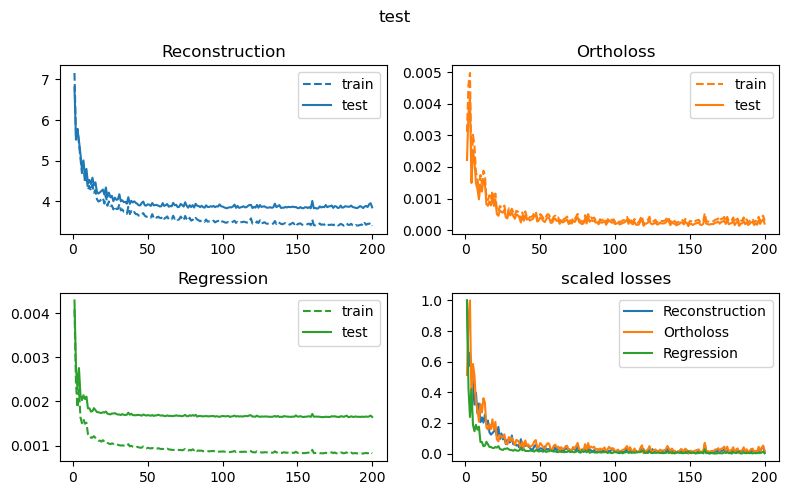

In [12]:

fig, axes = plt.subplots(2,2)
for dat, dname, ls in zip((autoencoder.train_scores, autoencoder.test_scores), ("train", "test"), ("--", "-")):
    xepochs = np.arange(dat.shape[0])+1
    for i,(ax,lname)in enumerate(zip(axes.flatten()[:3], ("Reconstruction", "Ortholoss", "Regression"))):
        ax.plot(xepochs, dat[:,i], ls=ls, color=f"C{i}", label=dname)
        minv = dat[:,i].min()
        maxv = dat[:,i].max()
        ax.set_title(lname)
        if(dname=="test"):
            axes[1,1].plot(xepochs, (dat[:,i]-minv)/(maxv-minv), ls=ls, color=f"C{i}", label=lname)

for ax in axes.flatten():
    ax.legend()
axes[1,1].set_title("scaled losses")
fig.suptitle(dname)
fig.set_size_inches(8,5)
fig.tight_layout()


In [13]:
# Train set

encoded_train = autoencoder.transform(train_X,batch_size=batch_size)
decoded_train = autoencoder.inverse_transform(encoded_train,batch_size=batch_size)
regressed_train = autoencoder.predict(train_X,batch_size=batch_size).numpy().squeeze()

encoded_train = encoded_train.numpy()

encoded_norm = encoded_train / np.sqrt((encoded_train**2).sum(axis=0))
print("enc.T @ enc", (encoded_train.T @ encoded_train), sep="\n")
print("(enc.T @ enc) / n", (encoded_train.T @ encoded_train)/encoded_train.shape[0], sep="\n")
print("enc_norm.T @ enc_norm", (encoded_norm.T @ encoded_norm), sep="\n")
print("OrthoLoss:", OrthoLoss()(torch.Tensor(encoded_train)).item(), sep="\n")
print("Cov:", np.cov(encoded_train.T), sep="\n")

print("regression")
error_train = np.abs(regressed_train - train_y)
print(f"L1 min: {error_train.min()} Å ")
print(f"L1 mean: {error_train.mean()} Å ")
print(f"L1 max: {error_train.max()} Å ")
error2_train = (regressed_train - train_y)**2
#print(f"L2 min: {error2_train.min()} Å^2")
print(f"mse: {error2_train.mean()} Å^2")
#print(f"L2 max: {error2_train.max()} Å^2")
print(f"L2: {np.sqrt(error2_train.mean())} Å")
print(f"r2: {r2_score(train_y, regressed_train)}")


print("reconstruction")
error_train = torch.mean(np.abs((decoded_train - train_X))).item()
print(f"L1 error: {error_train} Å ")
dists_train = torch.linalg.norm((decoded_train - train_X).reshape(train_X.shape[0], -1, 3), axis=-1).numpy()
error_train = dists_train.mean()
print(f"L1 dists: {error_train} Å ")
error_train = torch.max(torch.abs((decoded_train - train_X))).item()
print(f"Max L1 error: {error_train} Å ")
rmsd_train = torch.sqrt(torch.sum((decoded_train - train_X)**2, dim=(-1))/dists_train.shape[1]).numpy()
print(f"RMSD min: {rmsd_train.min()} Å ")
print(f"RMSD mean: {rmsd_train.mean()} Å ")
print(f"RMSD max: {rmsd_train.max()} Å ")

# Encoding scatter
df_t = {str(i): encoded_train[:,i] for i in range(encoded_train.shape[1])}
df_t["fval"] = train_y
df_t["rmsd"] = rmsd_train
df_t["pred"] = regressed_train
df_t["process"] = np.array(processes)[train_proc]

df_t = pd.DataFrame.from_dict(df_t)

enc.T @ enc
[[106883.695   5710.391 -26522.688]
 [  5710.391  87552.664  -3199.65 ]
 [-26522.688  -3199.65   95273.38 ]]
(enc.T @ enc) / n
[[ 1.46087824  0.07804919 -0.36251008]
 [ 0.07804919  1.19666317 -0.04373257]
 [-0.36251008 -0.04373257  1.30218937]]
enc_norm.T @ enc_norm
[[ 1.0000114   0.05903116 -0.26283264]
 [ 0.05903116  1.0000155  -0.03503372]
 [-0.26283264 -0.03503372  1.0000042 ]]
OrthoLoss:
0.06902654469013214
Cov:
[[ 6.79570325e-01  1.23328651e-02  1.56432964e-01]
 [ 1.23328651e-02  1.19115198e+00 -8.45165574e-05]
 [ 1.56432964e-01 -8.45165574e-05  9.57528726e-01]]
regression
L1 min: 8.821487426757812e-06 Å 
L1 mean: 0.3529339134693146 Å 
L1 max: 2.2998409271240234 Å 
mse: 0.2087181955575943 Å^2
L2: 0.4568568766117096 Å
r2: 0.7908536212103153
reconstruction
L1 error: 1.2845869064331055 Å 
L1 dists: 2.5712814331054688 Å 
Max L1 error: 35.281761169433594 Å 
RMSD min: 1.6442919969558716 Å 
RMSD mean: 3.02866792678833 Å 
RMSD max: 8.117330551147461 Å 


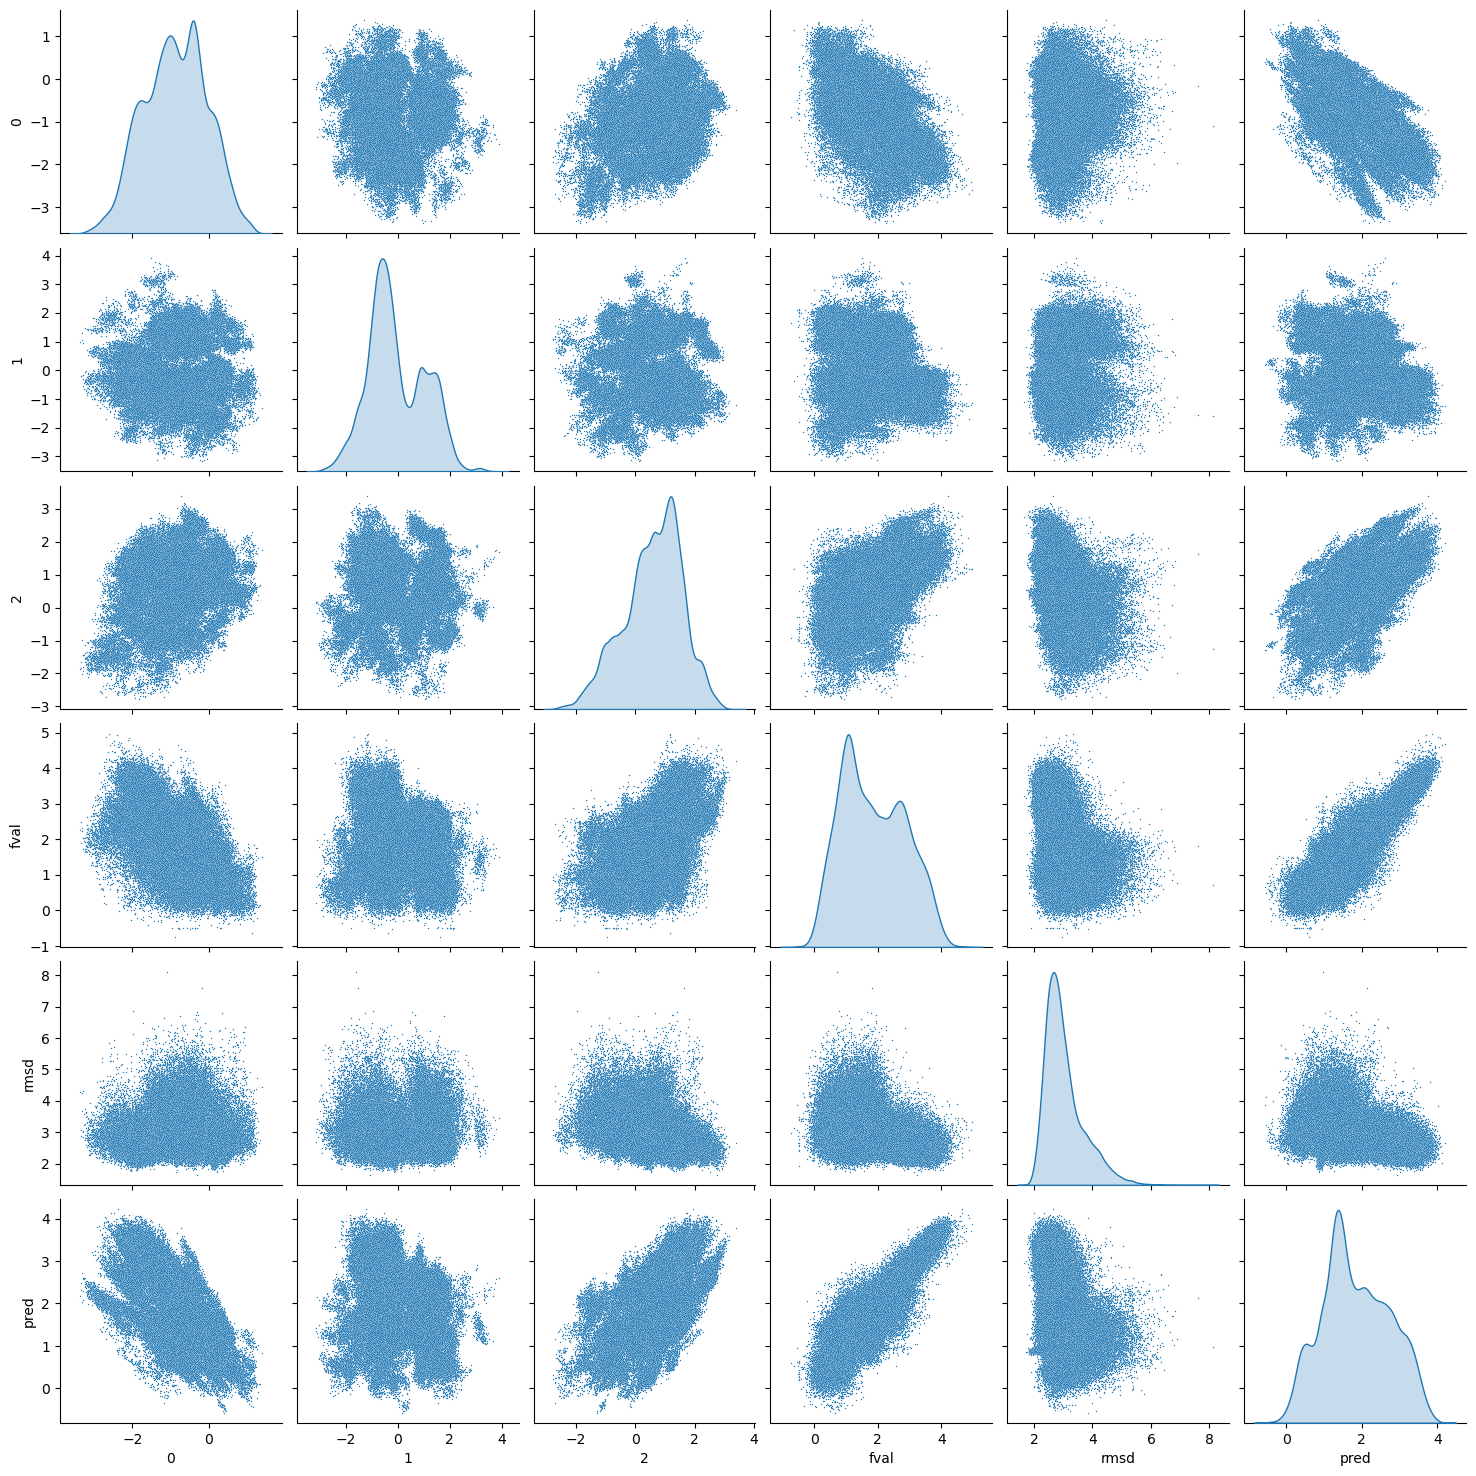

In [14]:
sns.pairplot(df_t, diag_kind="kde", plot_kws={"s":1})

In [15]:
# Test set

encoded = autoencoder.transform(test_X,batch_size=batch_size).numpy()
decoded = autoencoder.inverse_transform(encoded,batch_size=batch_size)
regressed = autoencoder.predict(test_X,batch_size=batch_size).numpy().squeeze(axis=-1)

In [16]:
encoded_norm = encoded / np.sqrt((encoded**2).sum(axis=0))
print("enc.T @ enc", (encoded.T @ encoded), sep="\n")
print("enc_norm.T @ enc_norm", (encoded_norm.T @ encoded_norm), sep="\n")
print("OrthoLoss:", OrthoLoss()(torch.Tensor(encoded)).item(), sep="\n")
print("Cov:", np.cov(encoded.T), sep="\n")

enc.T @ enc
[[25220.02    1100.225  -6026.2754]
 [ 1100.225  19906.652   -762.0616]
 [-6026.2754  -762.0616 21726.154 ]]
enc_norm.T @ enc_norm
[[ 1.0000019   0.04910329 -0.2574449 ]
 [ 0.04910329  1.000002   -0.03664367]
 [-0.2574449  -0.03664367  0.99999565]]
OrthoLoss:
0.04604260250926018
Cov:
[[ 0.59445799  0.01009049  0.18324434]
 [ 0.01009049  1.08519476 -0.0089424 ]
 [ 0.18324434 -0.0089424   0.852738  ]]


In [17]:
# reconstruction loss

error = (torch.abs((decoded - test_X))).mean().item()
print(f"L1 error: {error} Å ")
dists = torch.linalg.norm((decoded - test_X).reshape(test_X.shape[0], -1, 3), dim=-1).numpy()
error = dists.mean()
print(f"L1 dists: {error} Å ")
error = torch.max(torch.abs((decoded - test_X))).item()
print(f"Max L1 error: {error} Å ")
rmsd = torch.sqrt(torch.sum((decoded - test_X)**2, dim=(-1))/dists.shape[1]).numpy()
print(f"RMSD min: {rmsd.min()} Å ")
print(f"RMSD mean: {rmsd.mean()} Å ")
print(f"RMSD max: {rmsd.max()} Å ")


L1 error: 1.3799248933792114 Å 
L1 dists: 2.7624425888061523 Å 
Max L1 error: 36.12457275390625 Å 
RMSD min: 1.7949037551879883 Å 
RMSD mean: 3.232940435409546 Å 
RMSD max: 9.154964447021484 Å 


In [18]:
# regression loss

error = np.abs(regressed - test_y)
print(f"L1 min: {error.min()} Å ")
print(f"L1 mean: {error.mean()} Å ")
print(f"L1 max: {error.max()} Å ")
error2 = (regressed - test_y)**2
#print(f"L2 min: {error2.min()} Å^2")
print(f"L2 mean: {error2.mean()} Å^2")
#print(f"L2 max: {error2.max()} Å^2")
print(f"rmse: {np.sqrt(error2.mean())} Å")
print(f"r2: {r2_score(test_y, regressed)}")

L1 min: 1.3828277587890625e-05 Å 
L1 mean: 0.4999747574329376 Å 
L1 max: 3.0443010330200195 Å 
L2 mean: 0.4184989035129547 Å^2
rmse: 0.6469148993492126 Å
r2: 0.5806311921424768


In [19]:
# Encoding scatter
df = {str(i): encoded[:,i] for i in range(encoded.shape[1])}
df["rmsd"] = rmsd
df["fval"] = test_y
df["process"] = np.array(processes)[test_proc]
print(df["process"], df["process"].shape)

df = pd.DataFrame.from_dict(df)

['inactivation' 'no-Glu' 'no-Gly' ... 'desensitization' 'desensitization'
 'no-Gly'] (18291,)


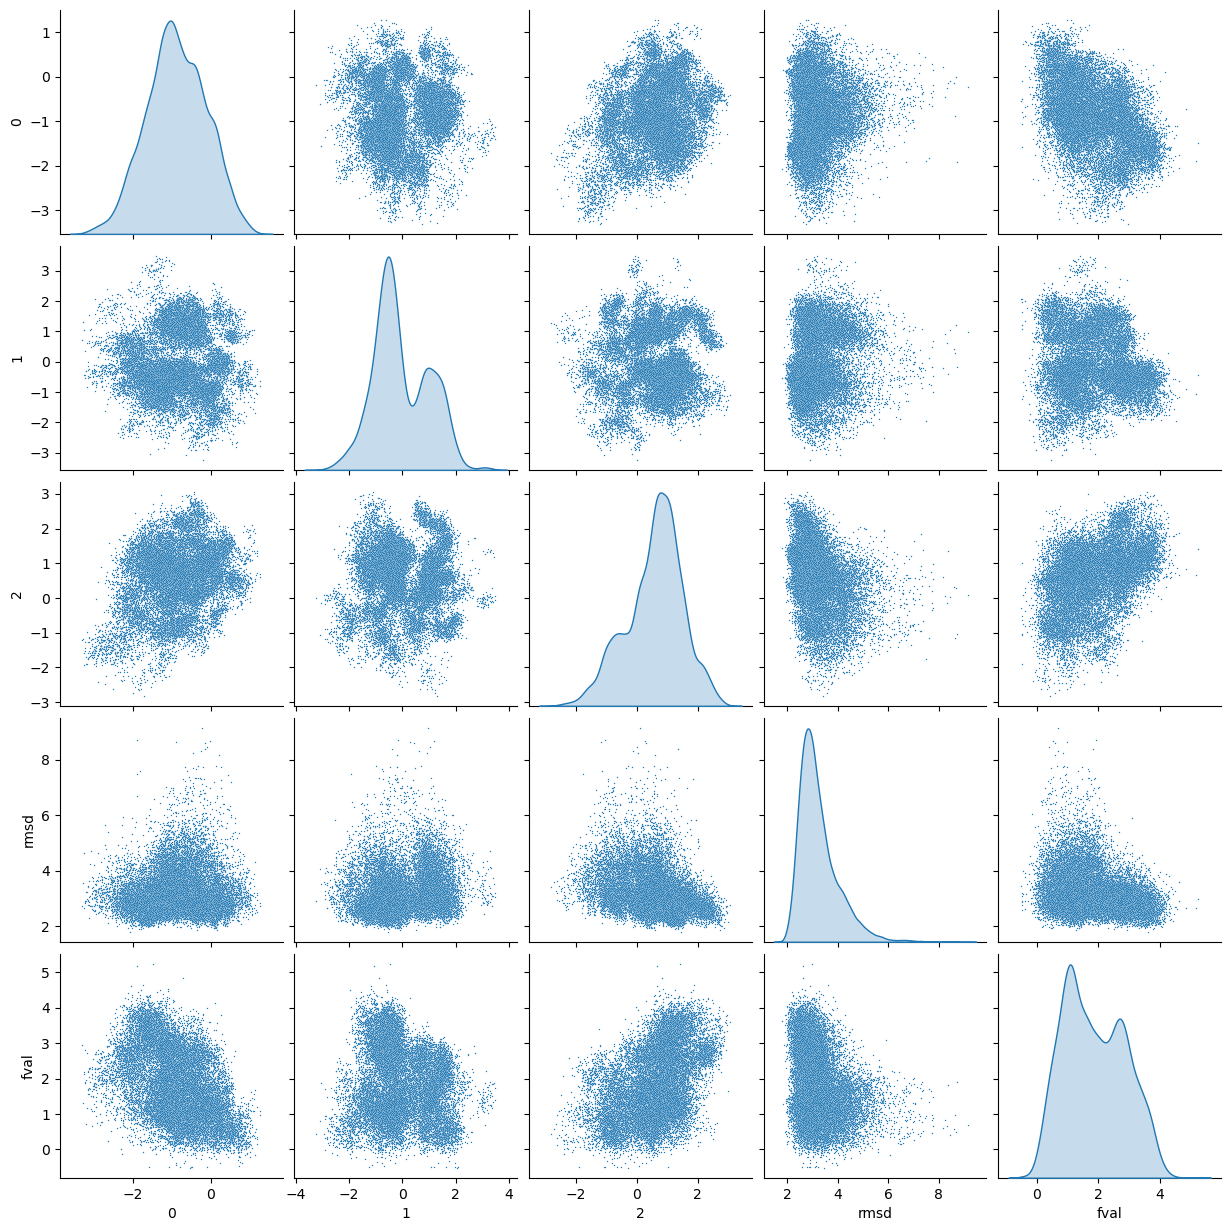

In [20]:
sns.pairplot(df, diag_kind="kde", plot_kws={"s":1})

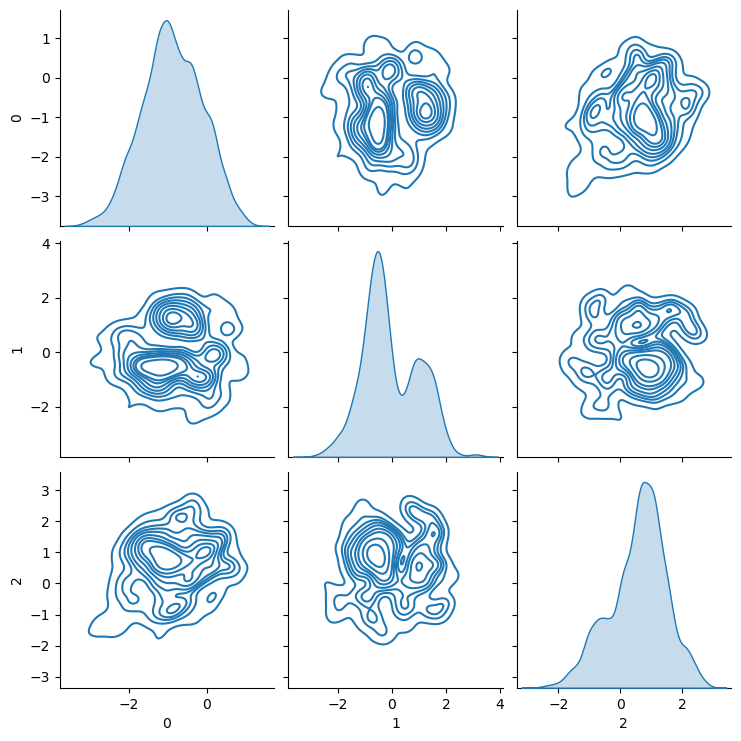

In [21]:
sns.pairplot(df, kind="kde", vars=[str(i) for i in range(encoded.shape[1])])

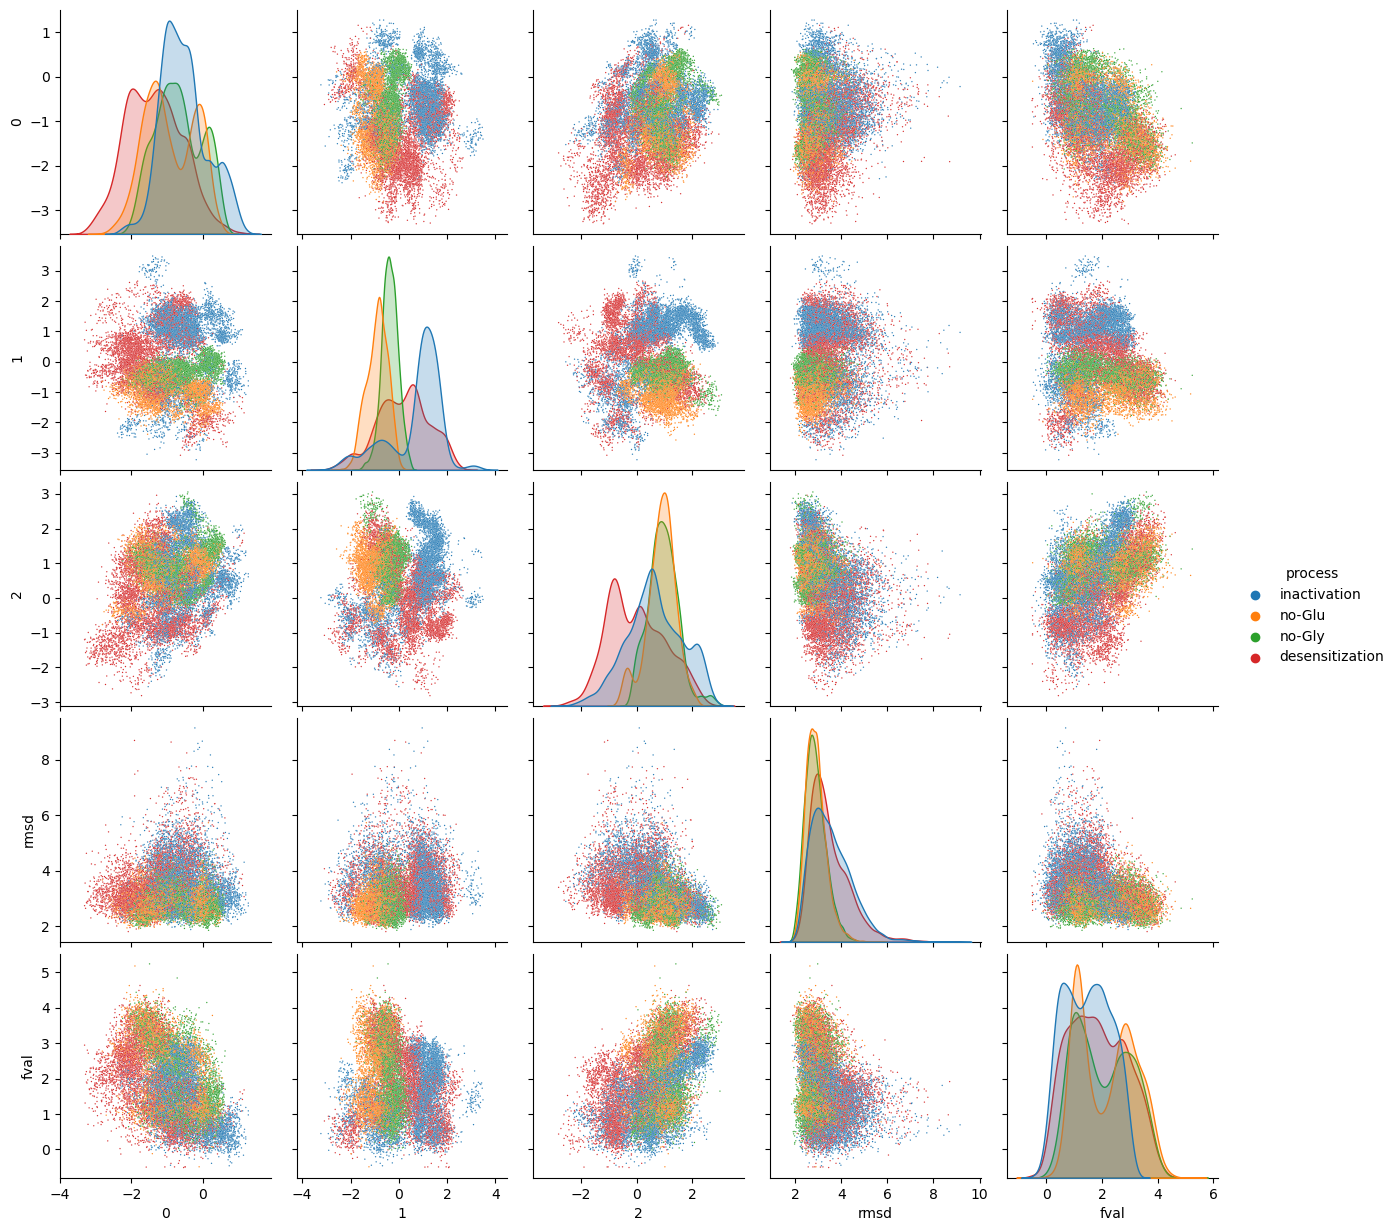

In [22]:
sns.pairplot(df, hue="process", plot_kws={"s":1})

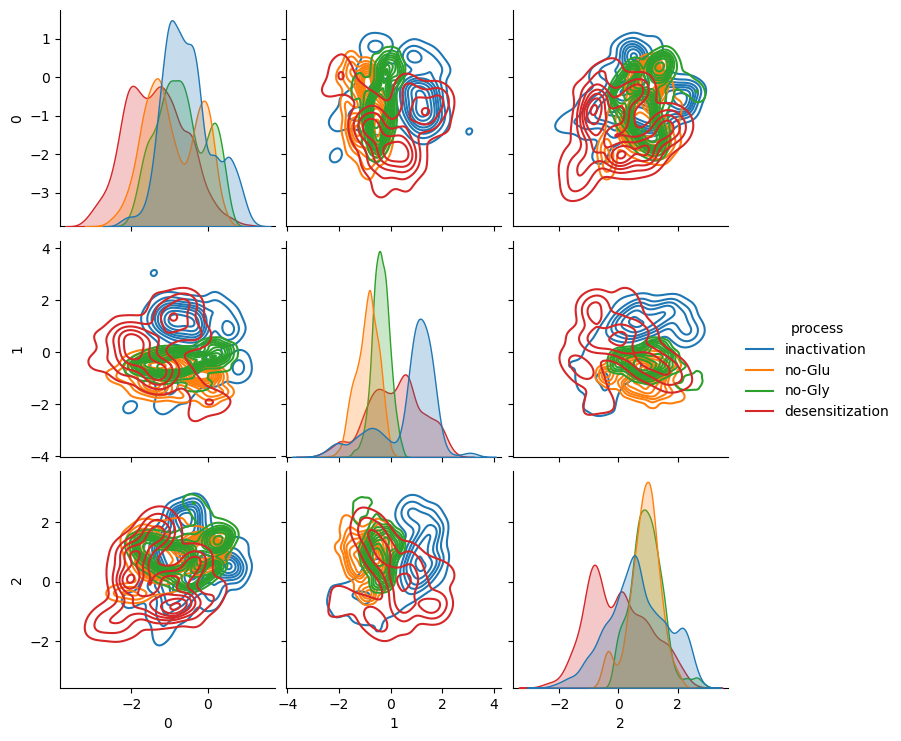

In [23]:
sns.pairplot(df, hue="process", kind="kde", vars=[str(i) for i in range(encoded.shape[1])])

/home/local/paajasan/micromamba/envs/pytorch/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/local/paajasan/micromamba/envs/pytorch/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/local/paajasan/micromamba/envs/pytorch/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


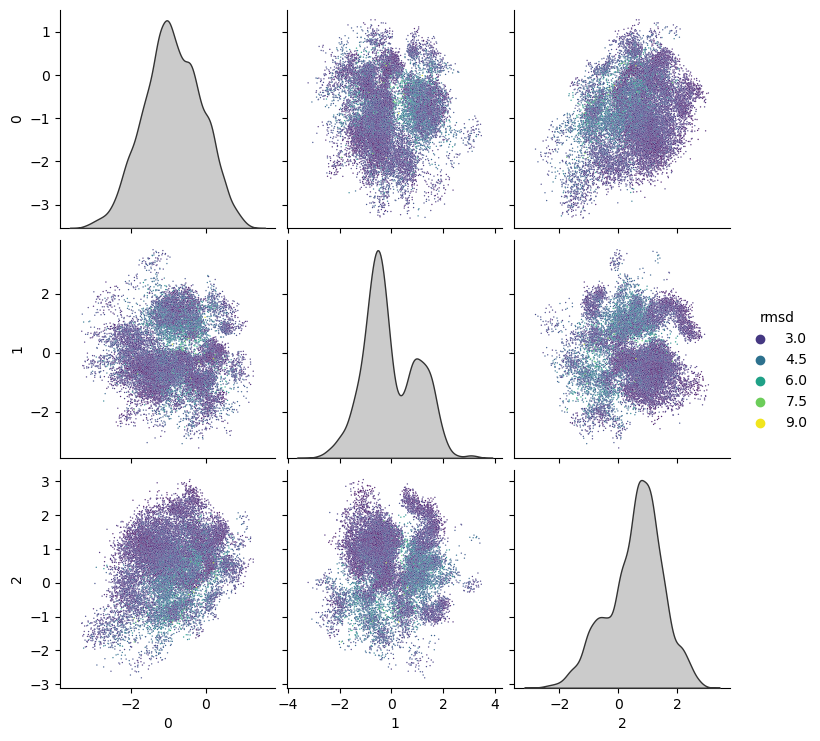

In [24]:
sns.pairplot(df, hue="rmsd", vars=[str(i) for i in range(encoded.shape[1])], palette="viridis", diag_kws={"color":".2","hue":None}, plot_kws={"s":1})

/home/local/paajasan/micromamba/envs/pytorch/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/local/paajasan/micromamba/envs/pytorch/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/local/paajasan/micromamba/envs/pytorch/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


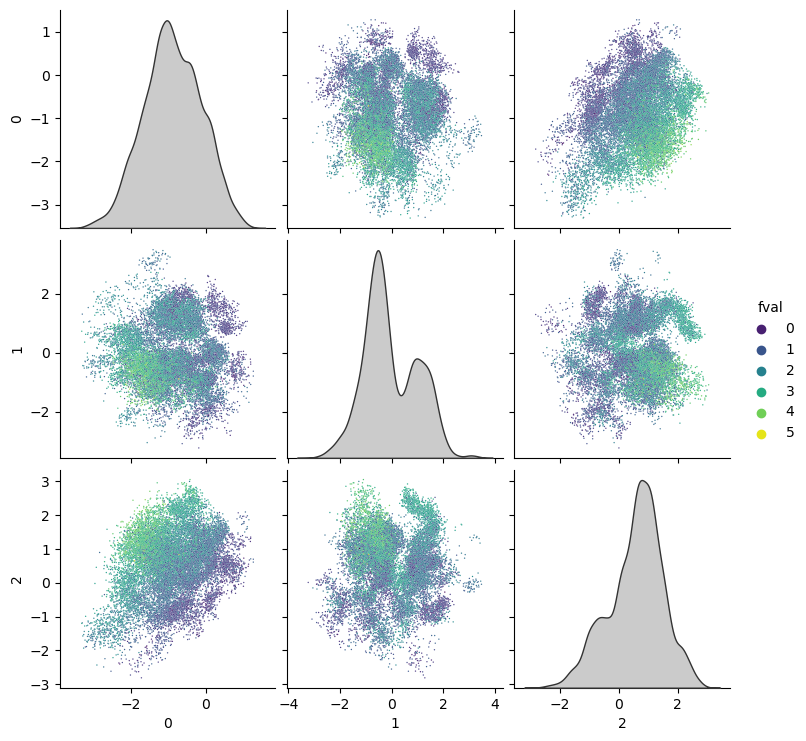

In [25]:
sns.pairplot(df, hue="fval", vars=[str(i) for i in range(encoded.shape[1])], palette="viridis", diag_kws={"color":".2","hue":None}, plot_kws={"s":1})

In [26]:
# Print numbers of data points for each process
_un_procs, _un_proc_counts = np.unique(train_proc, return_counts = True)
print("Train:")
for i,c in zip(_un_procs, _un_proc_counts):
    print(processes[i], c)

_un_procs, _un_proc_counts = np.unique(test_proc, return_counts = True)
print("\nTest:")
for i,c in zip(_un_procs, _un_proc_counts):
    print(processes[i], c)

Train:
no-Glu 16665
no-Gly 16562
desensitization 19982
inactivation 19955

Test:
no-Glu 4127
no-Gly 4101
desensitization 5018
inactivation 5045


In [27]:
# Save model parameters
outpath = pathlib.Path("results") / "Autoenc_params.pt"
torch.save(autoencoder.state_dict(), outpath)

moi='moi'


In [28]:
# If need be, load model parameters 

#device = 'cuda'
try:
    #raise NameError()
    autoencoder
    print(f"{autoencoder=} exists, no need to reload")
except NameError:
    autoencoder = Autoencoder(in_shape=in_shape,
                              pca_shape=pca_shape,
                              enc_shape=encoding_dim,
                              middle_shape=middle_dim,
                              n_hidden=n_hidden,
                              act_func=nn.ReLU,
                              #enc_act=nn.Tanh,
                              loss_fn=nn.MSELoss,
                              ortho_loss_w=1.0e-1,
                              device=device)

    inpath = pathlib.Path("results") / "Autoenc_params.pt"
    autoencoder.load_state_dict(torch.load(inpath, map_location=device))

autoencoder=Autoencoder(act_func=ReLU(), device='cuda:2', enc_shape=3, in_shape=5000,
            loss_fn=MSELoss(), middle_shape=16384, ortho_loss_w=0.1,
            pca_shape=77016) exists, no need to reload


In [29]:
# Calculate dimensionality reduction for all data
part="prot"
batch_size=512

for process in processes:
    struct = pathlib.Path(path) / process / data_folder / (part+".pdb")
    traj   = pathlib.Path(path) / process / data_folder / (part+".xtc")
    print(struct)
    u  = mda.Universe(str(struct), str(traj))
    sel = u.select_atoms(selection_strings[part])
    #sel = sel.select_atoms("name CA")
    
    data = {
        "encoded": [],
        "rmsd": [],
        "pred": []
    }

    bs = 50*batch_size
    batches = np.arange(0,len(u.trajectory),bs)
    for bi,i in enumerate(batches):
        X_b = np.empty((len(u.trajectory[i:i+bs]), X.shape[1]),dtype=np.float32)
        for j,_ in enumerate(tqdm(u.trajectory[i:i+bs], desc=process+f" ({bi}/{len(batches)})")):
            X_b[j] = sel.positions.ravel()
            
        enc = autoencoder.transform(X_b, batch_size=batch_size).numpy()
        dec = autoencoder.inverse_transform(enc, batch_size=batch_size).numpy()
        rmsd  = np.sqrt(((X_b-dec)**2).sum(axis=-1)/len(sel))
        pred  = autoencoder.predict_encoded(enc, batch_size=batch_size)
        
        data["encoded"].append(enc)
        data["rmsd"].append(rmsd)
        data["pred"].append(pred)
        
    for key in data:
        data[key] = np.concatenate(data[key])
        
    outfile = pathlib.Path("results") / process / (part+"_aa_data.npz")
    np.savez_compressed(outfile,
                        **data)

print("                           ")

/wrk2/paajasan/fst_applications/NMDA/no-Glu/analysis/prot.pdb


no-Glu (0/5): 100%|██████████████████████| 25600/25600 [00:49<00:00, 515.05it/s]


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'